In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/experiments/data"
X, y = get_data("bmm", base_dir, sample_rate=0.1)

df = pd.concat([X, y], axis=1)
df = df.dropna()
df = df[df["time"] > 0]
X, y = df.drop(columns=["time"]), df["time"]

100%|██████████| 72/72 [02:37<00:00,  2.18s/it]


In [3]:
n_iter = 10

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = RandomForestRegressor(random_state=random_seed)

param_dist = {
    "max_depth": [100, 150, 200],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [2, 5],
    "max_features": [10, 20, 50, 100, 1.0, "sqrt"],
    "n_estimators": [50, 100],
}

randomized_search = RandomizedSearchCV(
    estimator=tree_model,
    param_distributions=param_dist,
    n_iter=n_iter,  # Number of iterations to perform
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,
    random_state=random_seed,
    n_jobs=3,
)

/opt/miniconda3/envs/research/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 200}
Best MSE found:  -17.028667050278177
Train--------
Mean Squared Error: 4.291536952669872
MAPE: 0.020047784002926037
R-squared: 0.9989842307716682


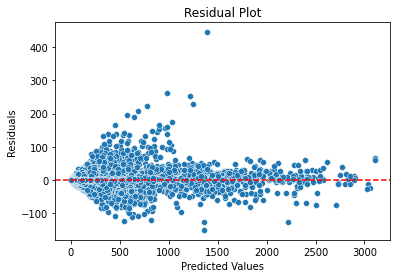

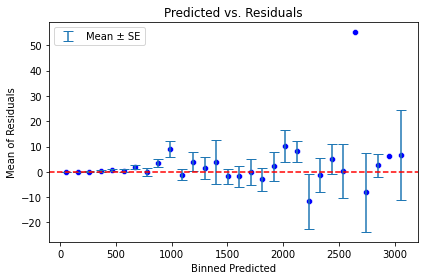

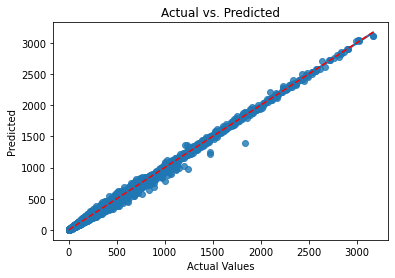

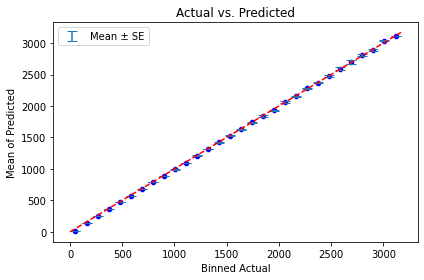

Val--------
Mean Squared Error: 16.003311945252623
MAPE: 0.03979685262784626
R-squared: 0.9959182135547024


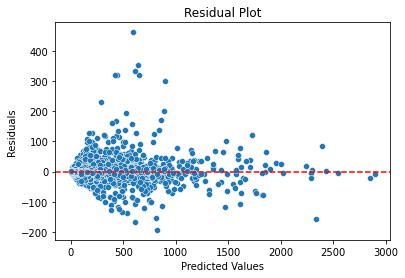

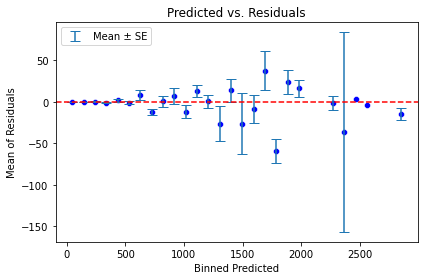

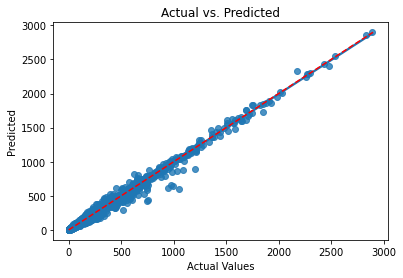

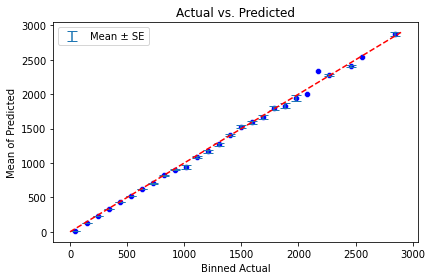

In [4]:
randomized_search.fit(X_cv, y_cv)
print("Best parameters found: ", randomized_search.best_params_)
print("Best MSE found: ", randomized_search.best_score_)

best_tree_model = randomized_search.best_estimator_
best_tree_model.fit(X_cv, y_cv)
run_val_pipeline(best_tree_model, X_cv, X_test, y_cv, y_test, bins=30)

In [5]:
# Note: since there are so many data points, we just take the best on 3 million data points then fit on the full dataset.